In [1]:
import os
from PIL import Image
from pathlib import Path
import torch as t
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import Generator
import Discriminator
import matplotlib.pyplot as plt

In [2]:
class AlphaMattingDataset(Dataset):
    def __init__(self, input_dir, gt_dir, trimaps):
        self.input_dir = input_dir
        self.gt_dir = gt_dir
        self.trimaps = trimaps
        self.images = os.listdir(self.input_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.input_dir, self.images[idx])
        tri_name = os.path.join(self.trimaps, self.images[idx])
        gt_name = os.path.join(self.gt_dir, self.images[idx])

        image = Image.open(img_name).convert("RGB")
        tri_image = Image.open(tri_name).convert("L")
        gt_image = Image.open(gt_name).convert("L")

        image = transformer(image)
        tri_image = transformer(tri_image)
        gt_image = transformer(gt_image)

        return image, tri_image, gt_image


class TestDataset(Dataset):
    def __init__(self, input_dir, trimap_dir, transform=None):
        self.input_dir = Path(input_dir)
        self.trimap_dir = Path(trimap_dir)
        self.transform = transform
        self.images = list(self.input_dir.glob('*.png'))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        img_name = img_path.stem
        img = Image.open(img_path).convert("RGB")
        trimap = Image.open(self.trimap_dir / (img_name + '.png')).convert("L")

        if self.transform:
            img = self.transform(img)
            trimap = self.transform(trimap)

        return img, trimap

In [3]:
transformer = transforms.Compose([transforms.ToTensor(), transforms.Resize((320, 320))])

# Train Dataset
train_dataset = AlphaMattingDataset(input_dir="Data/Train/InputImages", gt_dir="Data/Train/GroundTruthAlphas",
                                    trimaps="Data/Train/Trimaps/Trimap1")
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)

# Test Dataset
test_dataset = TestDataset(input_dir="Data/Test/InputImages", trimap_dir="Data/Test/Trimaps/Trimap1", transform=transformer)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [4]:
device = t.device("cuda" if t.cuda.is_available() else "cpu")

generator = Generator.Generator().to(device)
discriminator = Discriminator.PatchGANDiscriminator(patch_size=4).to(device)

model = "Model2"
generator.load_state_dict(t.load(f"{model}/generator.pth"))
discriminator.load_state_dict(t.load(f"{model}/discriminator.pth"))

num_to_show = 5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


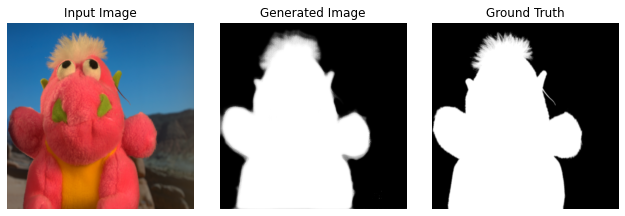

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


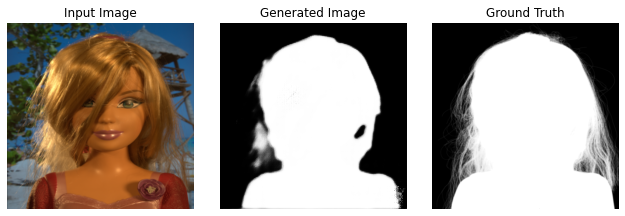

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


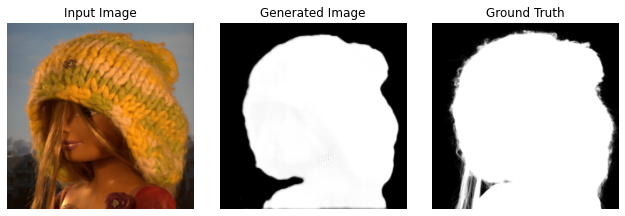

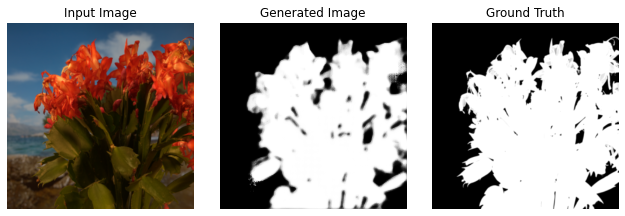

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


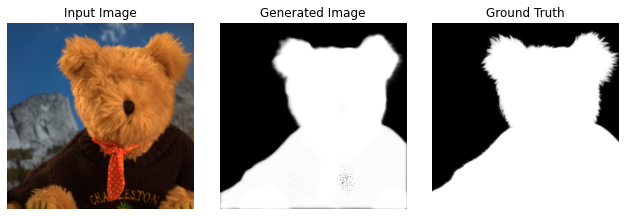

In [5]:
# Train Results
for i, (image, tri_image, gt_image) in enumerate(train_loader):
    image = image.to(device)
    tri_image = tri_image.to(device)
    gt_image = gt_image.to(device)

    input_img = t.cat((image, tri_image), dim=1).to(device)
    with t.no_grad():
        fake_alpha = generator(input_img)

    image_np = image.squeeze().to(device).numpy().transpose(1, 2, 0)
    fake_alpha_np = fake_alpha.squeeze().to(device).numpy()
    gt_np = gt_image.squeeze().to(device).numpy()

    fig, axs = plt.subplots(1, 3, figsize=(9, 3))
    axs[0].imshow(image_np)
    axs[0].set_title('Input Image')
    axs[0].axis('off')
    axs[1].imshow(fake_alpha_np, cmap='gray')
    axs[1].set_title('Generated Image')
    axs[1].axis('off')
    axs[2].imshow(gt_np, cmap='gray')
    axs[2].set_title('Ground Truth')
    axs[2].axis('off')
    plt.tight_layout()
    # plt.savefig(f"Results/Train/train{i+1}.pdf", bbox_inches="tight")
    plt.show()
    if i == num_to_show - 1:
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


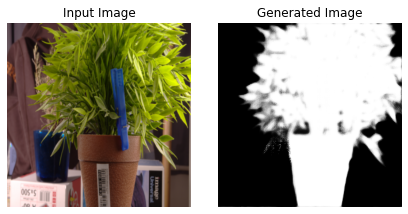

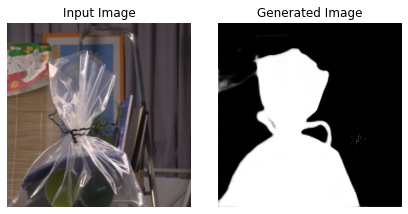

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


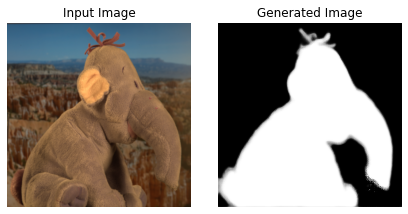

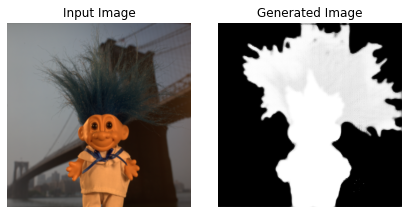

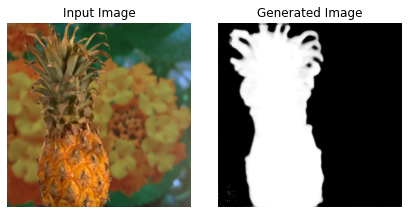

In [6]:
# Test Results
for i, (image, tri_image) in enumerate(test_loader):
    image = image.to(device)
    tri_image = tri_image.to(device)

    input_img = t.cat((image, tri_image), dim=1).to(device)
    with t.no_grad():
        fake_alpha = generator(input_img)

    image_np = image.squeeze().to(device).numpy().transpose(1, 2, 0)
    fake_alpha_np = fake_alpha.squeeze().to(device).numpy()

    fig, axs = plt.subplots(1, 2, figsize=(6, 3))
    axs[0].imshow(image_np)
    axs[0].set_title('Input Image')
    axs[0].axis('off')
    axs[1].imshow(fake_alpha_np, cmap='gray')
    axs[1].set_title('Generated Image')
    axs[1].axis('off')
    plt.tight_layout()
    # plt.savefig(f"Results/Test/test{i+1}.pdf", bbox_inches="tight")
    plt.show()
    if i == num_to_show - 1:
        break